In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas._testing import assert_series_equal  # noqa

from data.attribute import YEAR_ATTR, IS_PERMANENT_RESIDENT_ATTR, IS_CITIZEN_ATTR, AGE_ATTR, POPULATION_ATTR, SEX_ATTR, \
    COMMUNE_SIZE_ATTR, COMMUNE_SIZE_LABEL_MAPPER, SEX_LABEL_MAPPER

In [2]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [11]:
year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year]
population_year_df = population_df[(population_df[YEAR_ATTR] == year) & (population_df[IS_PERMANENT_RESIDENT_ATTR])]
electorate_year_df = population_year_df[(population_year_df[IS_CITIZEN_ATTR]) & (population_year_df[AGE_ATTR] >= 18)]

print(f'Year: {year}')
print(f'Number of selects respondents: {len(selects_year_df)}')
print(f'Population: {population_year_df[POPULATION_ATTR].sum()}')
print(f'Electorate: {electorate_year_df[POPULATION_ATTR].sum()}')

Year: 2019
Number of selects respondents: 6664
Population: 8606033
Electorate: 5291269


In [4]:
def merge_proportional(distribution: pd.Series, *distributions: tuple[pd.Series, ...]) -> pd.DataFrame:
    distributions = [distribution] + list(distributions)
    return pd.concat([d / d.sum() for d in distributions], axis=1)


def calculate_tvd(distribution: pd.DataFrame, reference: str) -> pd.Series:
    """
    Calculate Total Variation Distance between each column and a reference column.

    Args:
        distribution: DataFrame with probability distributions in columns
        reference: Name of the reference column to compare against

    Returns:
        Series with TVD values for each non-reference column
    """
    return pd.Series({
        column: (0.5 * (distribution[column] - distribution[reference]).abs().sum())
        for column in distribution.columns if column != reference
    })

<Axes: xlabel='Age'>

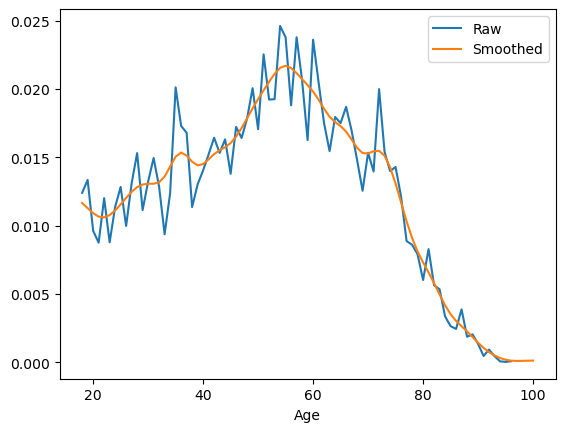

In [5]:
from data.selects import apply_age_smoothing

age_smoothed_selects_year_df = apply_age_smoothing(selects_year_df)

raw_selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Raw')
smoothed_selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Smoothed')
merge_proportional(raw_selects_age, smoothed_selects_age).sort_index().plot()

Uncorrected demographics TVD:
Selects               0.108281
Selects (weighted)    0.113488
Population            0.191168
dtype: float64


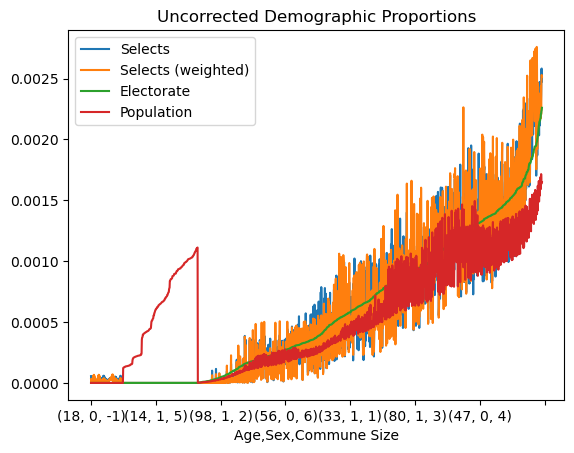

In [6]:
selects_demographics = age_smoothed_selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)['weightc'].sum().rename('Selects')
weighted_selects_demographics = age_smoothed_selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)['weighttot'].sum().rename('Selects (weighted)')

electorate_demographics = electorate_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)[POPULATION_ATTR].sum().rename('Electorate')
population_demographics = population_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)[POPULATION_ATTR].sum().rename('Population')

demographic_proportions = merge_proportional(
    selects_demographics, weighted_selects_demographics,
    electorate_demographics, population_demographics
).fillna(0).sort_values(['Electorate', 'Population'])

demographic_proportions.plot(title='Uncorrected Demographic Proportions')
print('Uncorrected demographics TVD:')
print(calculate_tvd(demographic_proportions, 'Electorate'))

In [7]:
from data.attribute import COMMUNE_SIZE_UNKNOWN

missing_population_demographics = demographic_proportions[demographic_proportions['Population'] == 0]
missing_population_commune_size = missing_population_demographics.index.get_level_values(COMMUNE_SIZE_ATTR).unique()

# All demographics that only appear in the selects data have an unknown commune size
assert missing_population_commune_size == [COMMUNE_SIZE_UNKNOWN]
missing_population_commune_size

Index([-1], dtype='int64', name=Commune Size)

In [8]:
missing_selects_demographics = demographic_proportions[demographic_proportions['Selects'] == 0]
missing_selects_demographics_count = len(missing_selects_demographics)


def _show_missing_proportion(description: str, mask: pd.Series) -> None:
    electorate_proportion = (missing_selects_demographics[mask]['Electorate'].sum() /
                             demographic_proportions['Electorate'].sum())
    print(f'{description}: {mask.sum()}/{missing_selects_demographics_count} demographics '
          f'({100 * electorate_proportion:.2f}% of electorate)')


is_underage = missing_selects_demographics.index.get_level_values(AGE_ATTR) < 18
_show_missing_proportion('Underage', is_underage)

OVERAGE_THRESHOLD = 85
is_overage = missing_selects_demographics.index.get_level_values(AGE_ATTR) > OVERAGE_THRESHOLD
_show_missing_proportion(f'Over age of {OVERAGE_THRESHOLD}', is_overage)

# All missing selects demographics are either underage or very old
missing_selects_demographics = missing_selects_demographics[~is_underage & ~is_overage]
assert len(missing_selects_demographics) == 0

Underage: 288/312 demographics (0.00% of electorate)
Over age of 85: 24/312 demographics (0.03% of electorate)


Clean uncorrected demographics TVD:
Selects               0.107052
Selects (weighted)    0.112361
Population            0.068896
dtype: float64
Proportion of electorate with unacceptable corrections:
Selects               0.011936
Selects (weighted)    0.014493
Population            0.000000
dtype: float64


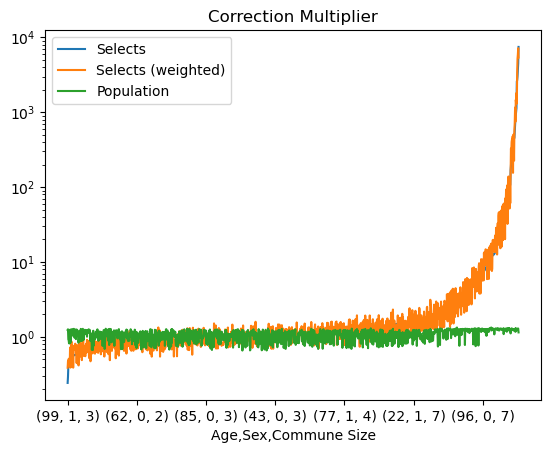

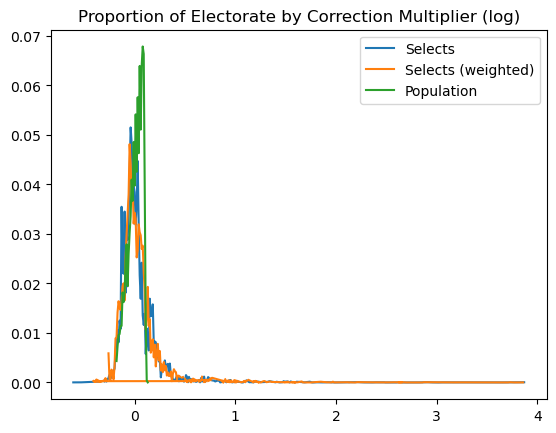

Corrected demographics TVD:
Population            0.0
Selects               0.0
Selects (weighted)    0.0
dtype: float64


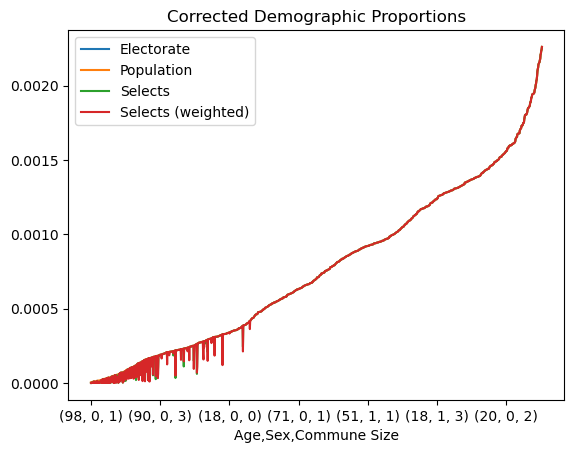

In [13]:
from data.selects import apply_demographic_correction

# Only use demographics present in both selects and population data
clean_demographic_proportions = demographic_proportions[
    (demographic_proportions['Selects'] > 0) & (demographic_proportions['Electorate'] > 0)
    ]
clean_demographic_proportions = clean_demographic_proportions.div(clean_demographic_proportions.sum(), axis=1)
print('Clean uncorrected demographics TVD:')
print(calculate_tvd(clean_demographic_proportions, 'Electorate'))

# Calculate required multiplier to correct selects' distribution
correction_multiplier = 1 / clean_demographic_proportions[['Selects', 'Selects (weighted)', 'Population']] \
    .div(clean_demographic_proportions['Electorate'], axis=0)
correction_multiplier.sort_values('Selects').plot(logy=True, title='Correction Multiplier')

# Check correction multiplier magnitude
multiplier_categories = np.round(np.log10(correction_multiplier), decimals=2)
multiplier_categories_proportion = pd.concat([
    clean_demographic_proportions['Electorate'].groupby(multiplier_categories[column]).sum().rename(column)
    for column in correction_multiplier.columns
], axis=1)
multiplier_categories_proportion.plot(title='Proportion of Electorate by Correction Multiplier (log)')

# Check for unacceptable multipliers
ACCEPTABLE_CORRECTION = 5
unacceptable_correction_proportion = pd.Series({
    column: clean_demographic_proportions['Electorate'][
        (correction_multiplier[column] > ACCEPTABLE_CORRECTION) |
        (correction_multiplier[column] < 1 / ACCEPTABLE_CORRECTION)
        ].sum()
    for column in correction_multiplier.columns
})
print('Proportion of electorate with unacceptable corrections:')
print(unacceptable_correction_proportion)
plt.show()

# Clip unacceptable multipliers
correction_multiplier = correction_multiplier.clip(upper=ACCEPTABLE_CORRECTION, lower=1 / ACCEPTABLE_CORRECTION)
corrected_demographic_proportions = clean_demographic_proportions.multiply(correction_multiplier)
corrected_demographic_proportions.plot(title='Corrected Demographic Proportions')
print('Corrected demographics TVD:')
print(calculate_tvd(corrected_demographic_proportions, 'Electorate'))

# Apply demographic correction to unweighted selects
DEMOGRAPHIC_WEIGHT = 'weight_demographic'
corrected_age_smoothed_selects_year_df = age_smoothed_selects_year_df.copy()
corrected_age_smoothed_selects_year_df[DEMOGRAPHIC_WEIGHT] = 0.0
for (age, sex, commune_size), factor in correction_multiplier['Selects'].items():
    mask = ((corrected_age_smoothed_selects_year_df[AGE_ATTR] == age) &
            (corrected_age_smoothed_selects_year_df[SEX_ATTR] == sex) &
            (corrected_age_smoothed_selects_year_df[COMMUNE_SIZE_ATTR] == commune_size))
    corrected_age_smoothed_selects_year_df.loc[mask, DEMOGRAPHIC_WEIGHT] = factor
for col in ('weightc', 'weightst', 'weightp', 'weighttot'):
    corrected_age_smoothed_selects_year_df[col] *= corrected_age_smoothed_selects_year_df[DEMOGRAPHIC_WEIGHT]

# Check if implementation results match
assert_series_equal(corrected_age_smoothed_selects_year_df['weightc'], apply_demographic_correction(
    age_smoothed_selects_year_df, electorate_year_df,
    acceptable_correction=ACCEPTABLE_CORRECTION,
)['weightc'])

Age distribution TVD:
Selects                0.067572
Selects (weighted)     0.057510
Selects (corrected)    0.005234
Population             0.091028
dtype: float64


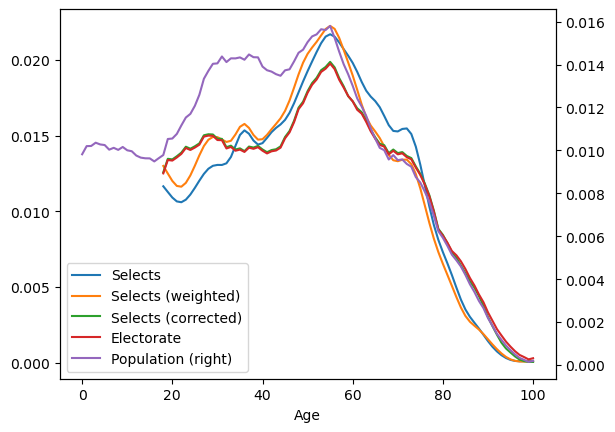

In [14]:
selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Selects')
weighted_selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum().rename('Selects (weighted)')
corrected_selects_age = corrected_age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Selects (corrected)')

electorate_age = electorate_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_age = population_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Population')

merge_proportional(
    selects_age, weighted_selects_age, corrected_selects_age, electorate_age, population_age
).sort_index().plot(secondary_y='Population')

# Calculate Total Variation Distance from electorate for all distributions
age_distribution = merge_proportional(selects_age, weighted_selects_age, corrected_selects_age, electorate_age,
                                      population_age)
print('Age distribution TVD:')
print(calculate_tvd(age_distribution, 'Electorate'))

Sex distribution TVD:
Selects                0.019075
Selects (weighted)     0.002822
Selects (corrected)    0.001553
Population             0.017132
dtype: float64


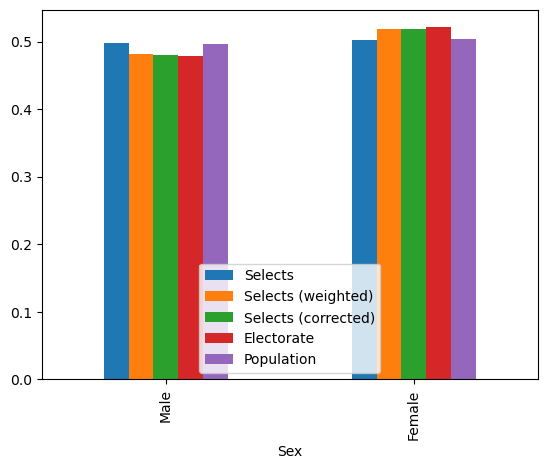

In [15]:
selects_sex = age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects')
weighted_selects_sex = age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weighttot'].sum() \
    .rename('Selects (weighted)')
corrected_selects_sex = corrected_age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects (corrected)')
electorate_sex = electorate_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_sex = population_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Population')

sex_distribution = merge_proportional(
    selects_sex, weighted_selects_sex, corrected_selects_sex, electorate_sex, population_sex
).rename(SEX_LABEL_MAPPER)
sex_distribution.plot(kind='bar')
print('Sex distribution TVD:')
print(calculate_tvd(sex_distribution, 'Electorate'))

Commune size distribution TVD:
Selects                0.016530
Selects (weighted)     0.025512
Selects (corrected)    0.002710
Population             0.032834
dtype: float64


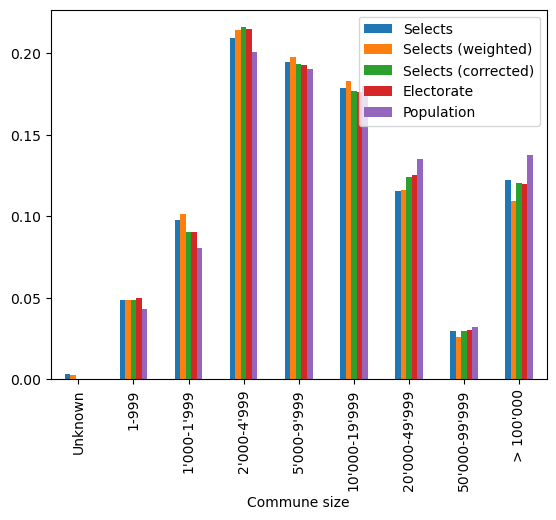

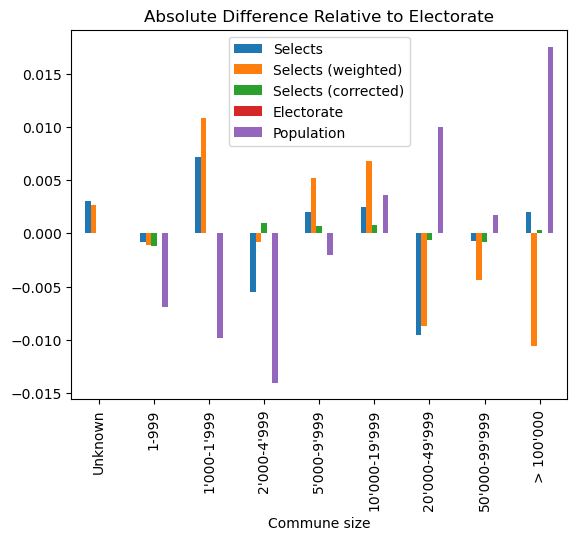

In [16]:
selects_commune_size = selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weightc'].sum().rename('Selects')
weighted_selects_commune_size = selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weighttot'].sum().rename('Selects (weighted)')
corrected_selects_commune_size = corrected_age_smoothed_selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weightc'].sum().rename('Selects (corrected)')

electorate_commune_size = electorate_year_df.groupby(COMMUNE_SIZE_ATTR) \
    [POPULATION_ATTR].sum().rename('Electorate')
population_commune_size = population_year_df.groupby(COMMUNE_SIZE_ATTR) \
    [POPULATION_ATTR].sum().rename('Population')

commune_size_distribution = merge_proportional(
    selects_commune_size, weighted_selects_commune_size, corrected_selects_commune_size,
    electorate_commune_size, population_commune_size
).fillna(0)

commune_size_distribution.rename(COMMUNE_SIZE_LABEL_MAPPER).plot(kind='bar', xlabel='Commune size')
(commune_size_distribution.sub(commune_size_distribution['Electorate'], axis=0)).rename(COMMUNE_SIZE_LABEL_MAPPER).plot(
    kind='bar', xlabel='Commune size', title='Absolute Difference Relative to Electorate')
print('Commune size distribution TVD:')
print(calculate_tvd(commune_size_distribution, 'Electorate'))